# Table of Contents

1. Load and Check data
    * Load Libraries
    * Load data
2. Exploratory Data Analysis, Data Cleaning, Feature Engineering
    * Outlier Detection
    * Feature Analysis for Numerical Variables
    * Feature Analysis for Categorical Variables
    * Filling Missing Values & Feature Engineering
3. Function for Feature Engineering
4. Modelling
5. Prediction

## 1. Load Libraries and Dataset

### 1.1 Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

### 1.2 Load Dataset

In [2]:
# load in train set and test set from the CSV files
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

# display first 5 rows of the train set
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# data types of each feature
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The **Survived** is the target variable of this completition. It is a binary data tpye of 1 for survived and 0 for not survived.<br>

**PassengerId** should not be helpful for the prediction. Let's drop this variable and take a quick look at the remaining variables.

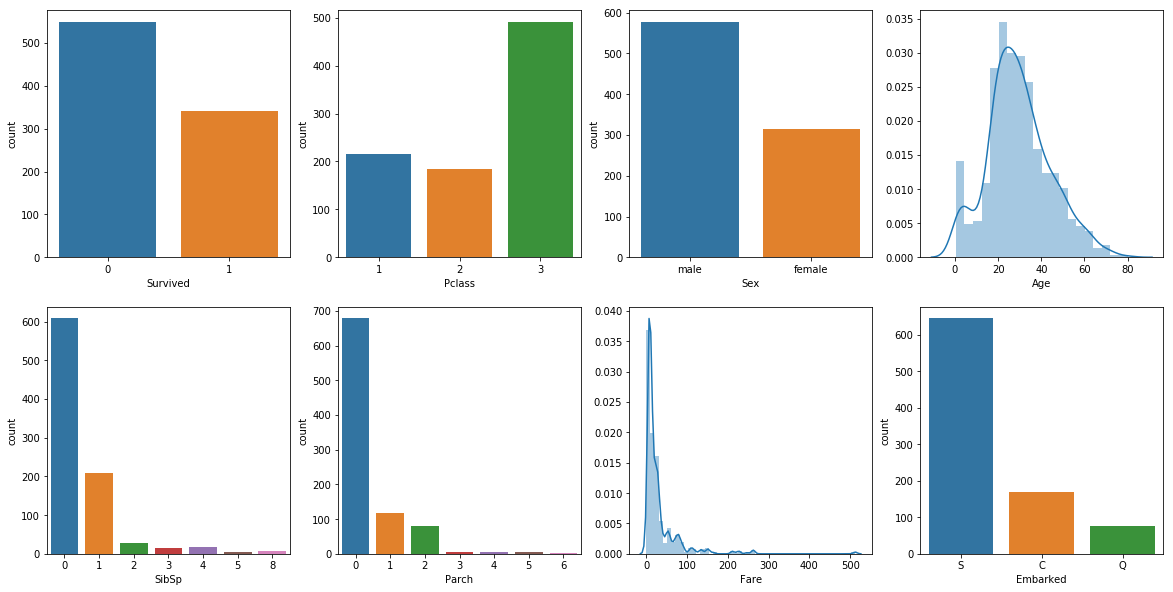

In [4]:
# quick look at independent variables
f, ax = plt.subplots(2, 4, figsize=(20, 10))
sns.countplot('Survived', data=train_df, ax=ax[0, 0])
sns.countplot('Pclass', data=train_df, ax=ax[0, 1])
sns.countplot('Sex', data=train_df, ax=ax[0, 2])
sns.distplot(train_df['Age'].dropna(), ax=ax[0, 3])
sns.countplot('SibSp', data=train_df, ax=ax[1, 0])
sns.countplot('Parch', data=train_df, ax=ax[1, 1])
sns.distplot(train_df['Fare'], ax=ax[1, 2])
sns.countplot('Embarked', data=train_df, ax=ax[1, 3])

# 2. Exploratory Data Analysis, Data Cleaning, Feature Engineering

### 2.1 Outlier Detection
There are potential outliers in the data. Let's find out these abnormal data by implementing the Tukey method.

In [5]:
# define a function to detect outliers
def detect_outliers(df, n, features):
    """
    return a list of indices corresponding to the observation containing 
    more n outliers according to Tukey method
    """
    
    outlier_indices = []
    
    # iterate over columns
    for col in features:
        # first quartile
        Q1 = np.percentile(df[col], 25)
        # third quartile
        Q3 = np.percentile(df[col], 75)
        # inter-quartile range
        IQR = Q3 - Q1
        upper_range = Q3 + 1.5 * IQR
        lower_range = Q1 - 1.5 * IQR
        
        # a list of indices of outliers
        outlier_col_indices = df[(df[col] < lower_range) | (df[col] > upper_range)].index
        
        outlier_indices.extend(outlier_col_indices)
    
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = [k for k, v in outlier_indices.items() if v > n]
    
    return multiple_outliers

# find out outliers from train_data with n = 2
outlier_indices = detect_outliers(train_df, 2, 
                                  ["Age", "SibSp", "Parch", "Fare"])

In [6]:
# display outliers
train_df.loc[outlier_indices]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


The function found out 10 outliers.<br>
3 of them have an high ticket fare.<br>
The others have a high value of SibSp and have a missing value for Age.

In [7]:
# remove observations containing outliers
# reset index
# train_df = train_df.drop(outlier_indices, axis = 0).reset_index(drop = True)

### 2.2 Feature Analysis for Numerical Variables

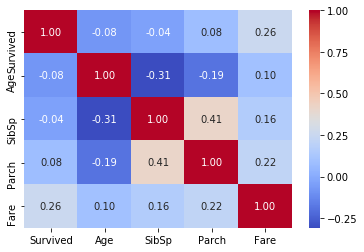

In [8]:
# correlation matrix between numerical variables and Survived
sns.heatmap(train_df[["Survived", "Age", "SibSp", "Parch", "Fare"]].corr(),
            annot = True, fmt = ".2f", cmap = "coolwarm")

Only **Fare** have a significant correlation with **Survived**.

#### Age

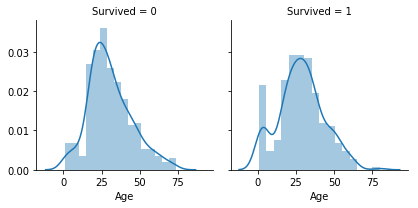

In [9]:
# Age vs Survived
g = sns.FacetGrid(train_df, col = "Survived")
g = g.map(sns.distplot, "Age")

they both looked like normally distributed

a peak corresponding to young passengers in the plot Survived = 1 <br>
=> very young passengers have high survival rate

passengers > 60 year-old is unlikely to survive

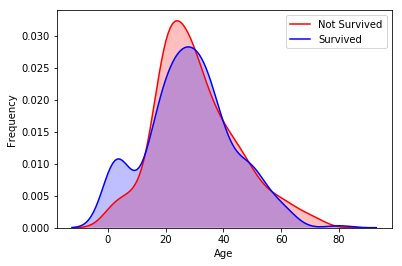

In [10]:
# Age distribution
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 0) & 
                                  (train_df["Age"].notnull())],
               color = "Red", shade = True)
g = sns.kdeplot(train_df["Age"][(train_df["Survived"] == 1) &
                                 (train_df["Age"].notnull())],
               color = "Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

the peak corresponding to very young passengers shows that they have much higher chance to survive

#### SibSp

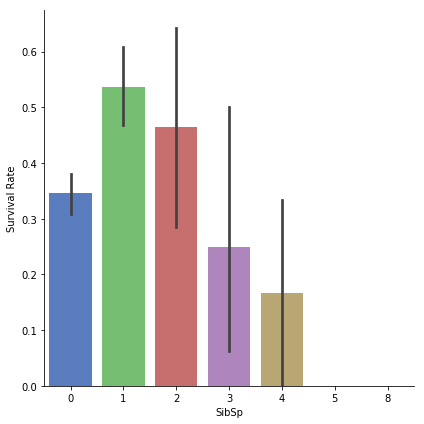

In [11]:
# SibSp
g = sns.factorplot(data = train_df, x = "SibSp", y = "Survived", 
                   kind = "bar", size = 6, palette = "muted")
g.set_ylabels("Survival Rate")

less chance to survive if a lot of siblings/spouses on board

#### Parch

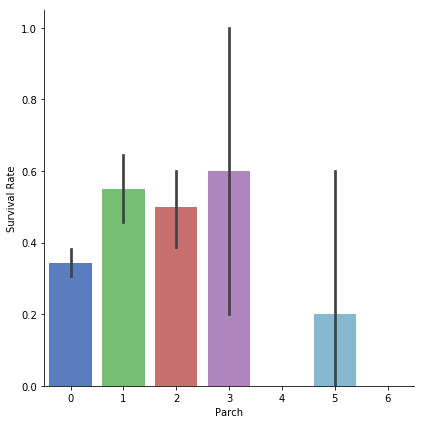

In [12]:
# Parch
g = sns.factorplot(data = train_df, x = "Parch", y = "Survived",
                   kind = "bar", size = 6, palette = "muted")
g.set_ylabels("Survival Rate")

small family have more chance to survive

#### Fare

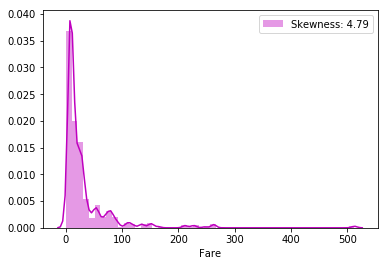

In [13]:
# Fare distribution
g = sns.distplot(train_df["Fare"], color = "m", 
                 label = "Skewness: %.2f" %(train_df["Fare"].skew()))
g.legend(loc = "best")

highly skewed<br>
=> lead to overweight very high values in the model

should be transformed with log function to reduce skewness

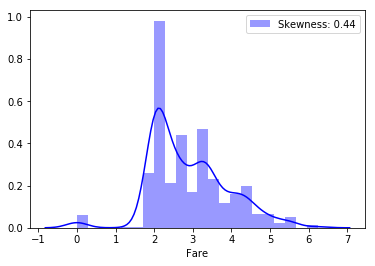

In [14]:
g = sns.distplot(train_df["Fare"].map(lambda x: np.log(x) if x > 0 else 0), 
                 color = "b", 
                 label = "Skewness: %.2f" 
                 %(train_df["Fare"].map(lambda x: np.log(x) if x > 0 else 0).skew()))
g.legend(loc = "best")

The skewness is much lower now.

### 2.3 Feature Analysis for Categorical Variables

#### Sex

Text(0,0.5,'Survival Rate')

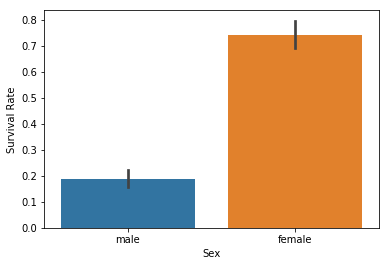

In [15]:
# Sex
g = sns.barplot(data = train_df, x = "Sex", y = "Survived")
g.set_ylabel("Survival Rate")

Female has a much more chance to survive<br>
=> Sex might play an important role in the prediction

#### Pclass

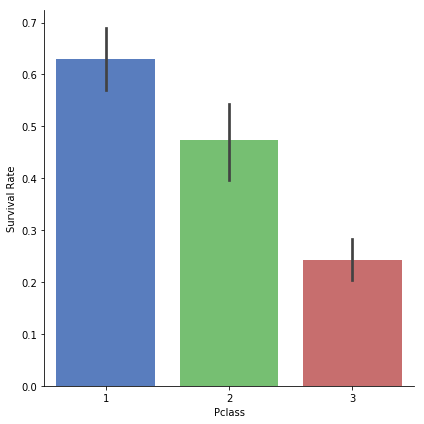

In [16]:
# Pclass
g = sns.factorplot(data = train_df, x = "Pclass", y = "Survived",
                   kind = "bar", size = 6, palette = "muted")
g.set_ylabels("Survival Rate")

Class 1 has the highest probability to survive, then Class 2

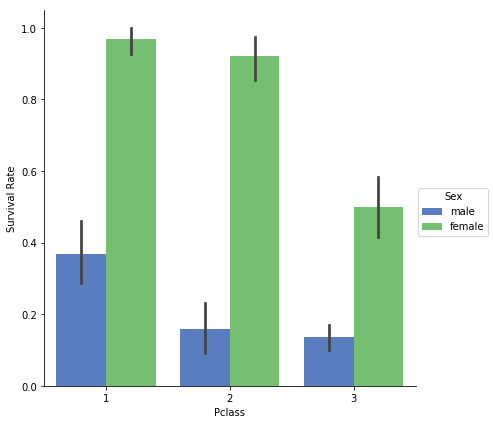

In [17]:
# Survived against Pclass by Sex
g = sns.factorplot(data = train_df, x = "Pclass", y = "Survived", hue = "Sex",
                   kind = "bar", size = 6, palette = "muted")
g.set_ylabels("Survival Rate")

the trend is conserved when look at both male and female passengers

#### Embarked

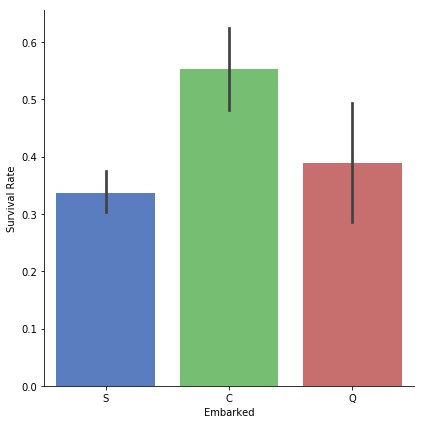

In [18]:
# Embarked
g = sns.factorplot(data = train_df, x = "Embarked", y = "Survived",
                   kind = "bar", size = 6, palette = "muted")
g.set_ylabels("Survival Rate")

survival rate: C > Q > S

more first class passengers came from C?

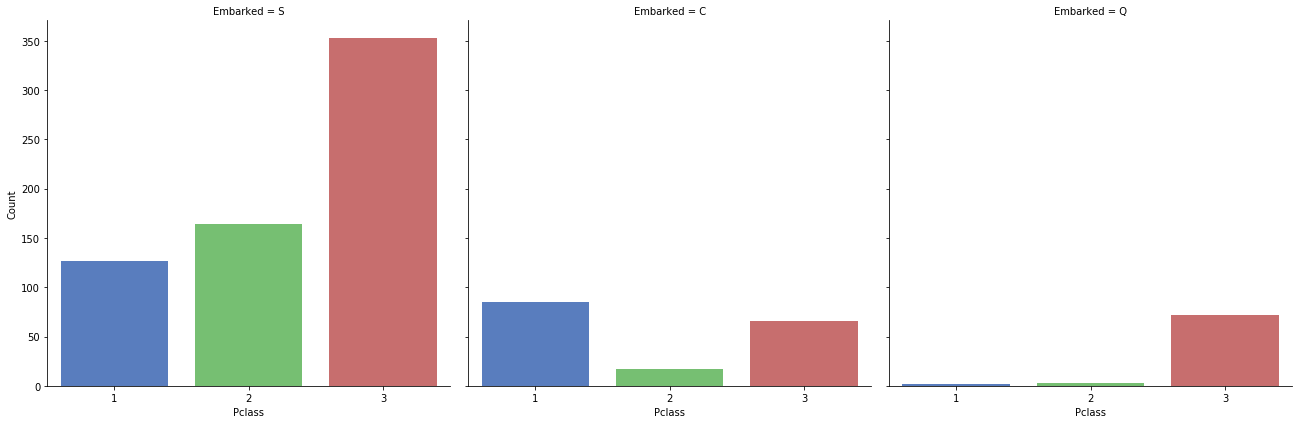

In [19]:
# Pclass by Embarked
g = sns.factorplot(data = train_df, x = "Pclass", col = "Embarked",
                   kind = "count", size = 6, palette = "muted")
g.set_ylabels("Count")

third class is the most frequent for passengers coming from S and Q

passengers from C are mostly in the first class 

#### Name_length

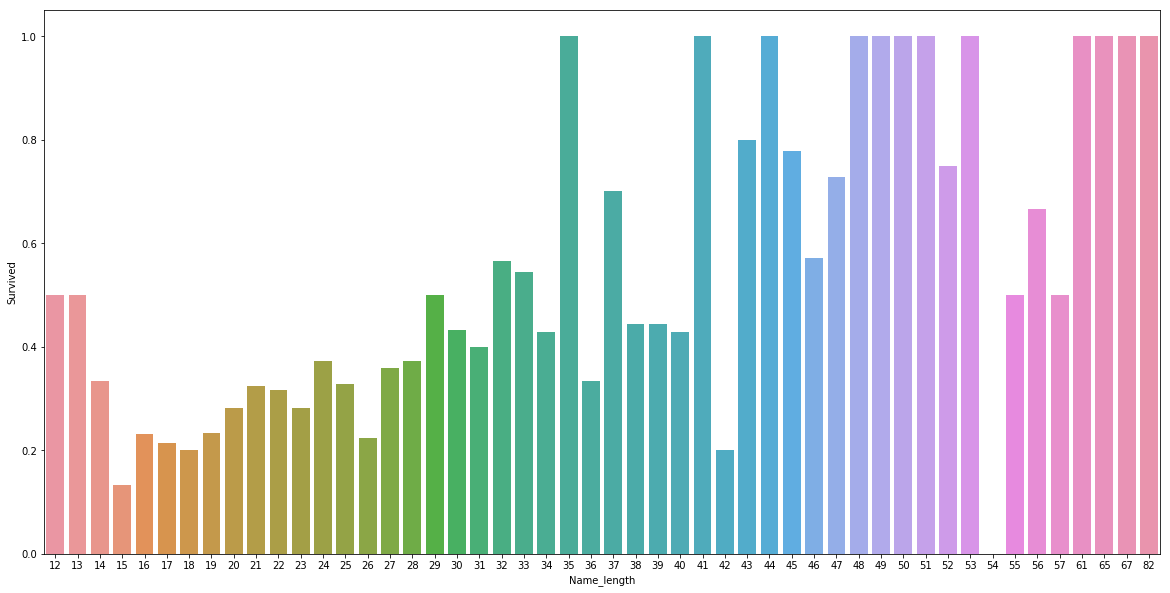

In [20]:
temp_df = train_df[['Name', 'Survived']].copy()
temp_df['Name_length'] = train_df['Name'].apply(len)

plt.figure(figsize=(20, 10))
sns.barplot(x='Name_length', y='Survived', data=temp_df, ci=None)

passengers with longer name tend to have a higher chance to survive

**Name_length** may be important for the prediction

#### Cabin

In [21]:
temp_df = train_df[['Cabin', 'Survived']].copy()
temp_df['Has_Cabin'] = train_df['Cabin'].apply(lambda x: 0 if x is np.nan else 1)

temp_df[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Has_Cabin,Survived
1,1,0.666667
0,0,0.299854


Passengers with **Cabin** values have a higher chance to survive<br>
**Cabin** is another important variable for the prediction

#### Ticket_length

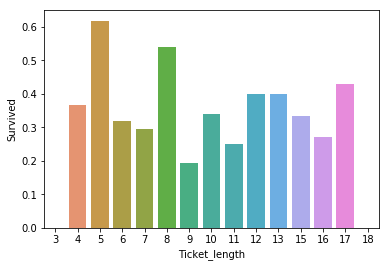

In [22]:
temp_df = train_df[['Ticket', 'Survived']].copy()
temp_df['Ticket_length'] = temp_df['Ticket'].apply(len)

sns.barplot(x='Ticket_length', y='Survived', data=temp_df, ci=None)

higher survival rate in **Ticket_length** = 5 and **Ticket_length** = 8

### 2.4 Filling Missing Values & Feature Engineering

In [23]:
# display number of missing data in train set
train_df.isnull().sum()[train_df.isnull().sum() > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [24]:
# display number of missing data in test set
test_df.isnull().sum()[test_df.isnull().sum() > 0]

Age       86
Fare       1
Cabin    327
dtype: int64

#### Age

Age column has 177 missing values in the train set

very young passengers have more change to survive, need to keep age feature and to impute the missing values

use the most correlated features with Age to fill the missing values

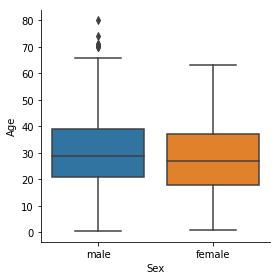

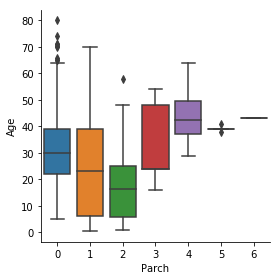

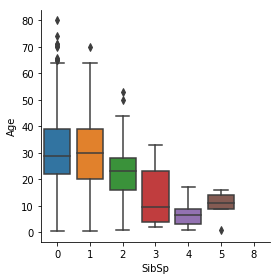

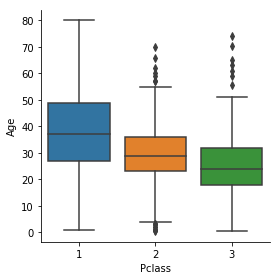

In [25]:
# Explore Age against Sex, Parch, SibSp, Pclass
g = sns.factorplot(x = "Sex", y = "Age", data = train_df, kind = "box")
g = sns.factorplot(x = "Parch", y = "Age", data = train_df, kind = "box")
g = sns.factorplot(x = "SibSp", y = "Age", data = train_df, kind = "box")
g = sns.factorplot(x = "Pclass", y = "Age", data = train_df, kind = "box")

Sex: seems to have same distribution => not informative to predict Age

Parch: more parents/children => older

SibSp: more siblings/spouses => younger

Pclass: age of class 1 > age of class 2 > age of class 3

In [26]:
# convert Sex into categorical value 0 for male and 1 for female
train_df["Sex"] = train_df["Sex"].map({"male": 0, "female": 1})

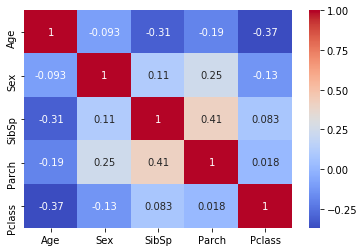

In [27]:
g = sns.heatmap(train_df[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(),
                cmap = "coolwarm", annot = True)

Age is not correlated with Sex, but negatively correlated with SibSp, Parch, Pclass

correlation of Age with Parch is not conserved to the conclusion of the boxplot above

fill Age with the median age of similar rows according to Pclass, Parch, SibSp

In [28]:
# find out indices of observations with NaN age values
index_NaN_age = list(train_df["Age"][train_df["Age"].isnull()].index)

# fill in missing values
age_med = train_df["Age"].median()
for i in index_NaN_age:
    age_pred = train_df["Age"][((train_df["Pclass"] == train_df.iloc[i]["Pclass"]) &
                              (train_df["Parch"] == train_df.iloc[i]["Parch"]) &
                              (train_df["SibSp"] == train_df.iloc[i]["SibSp"]))].median()
    if np.isnan(age_pred):
        train_df["Age"].iloc[i] = age_med
    else:
        train_df["Age"].iloc[i] = age_pred

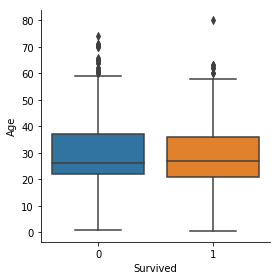

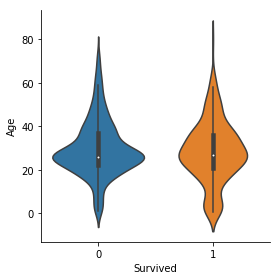

In [29]:
# display the updated Age
g = sns.factorplot(x = "Survived", y = "Age", data = train_df, kind = "box")
g = sns.factorplot(x = "Survived", y = "Age", data = train_df, kind = "violin")

no difference between median value of age

very young passengers have higher survival rate

#### Cabin

Cabin has 687 missing values in train set.<br>
We cannot drop it because of its strong impact on the Survival rate.

In [30]:
# display some existing Cabin values in train set
train_df[train_df['Cabin'].notnull()]['Cabin'].values[:30]

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73',
       'C23 C25 C27', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60',
       'E101', 'D26', 'F E69', 'D47', 'C123', 'B86', 'F2'], dtype=object)

**Cabin** consists of 1 letter and numbers.<br>
Extract the first letter as a new variable and fill the missing values with "other"

In [31]:
# create a new variable Has_Cabin
train_df['Has_Cabin'] = train_df['Cabin'].apply(lambda x: 0 if x is np.nan else 1)
train_df['Cabin_letter'] = train_df['Cabin'].apply(lambda x: 'other' if x is np.nan 
                                                   else str(x)[0])

In [32]:
# check the Cabin_letter
train_df['Cabin_letter'].value_counts()

other    687
C         59
B         47
D         33
E         32
A         15
F         13
G          4
T          1
Name: Cabin_letter, dtype: int64

#### Family Size

In [33]:
train_df["family_size"] = train_df["Parch"] + train_df["SibSp"] + 1

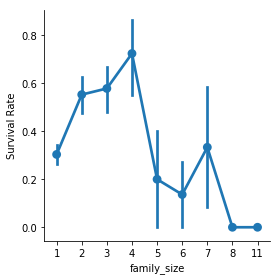

In [34]:
g = sns.factorplot(x = "family_size", y = "Survived", data = train_df)
g.set_ylabels("Survival Rate")

less survival rate for large family

#### Name/ Title

In [35]:
# take a look at Name
train_df["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The titles is just after the ", "

Let's split the Name and Extract the tilte

In [36]:
# get all titles from names
dataset_title = train_df["Name"].str.split(", ", expand = True)[1]
dataset_title = dataset_title.str.split(". ", expand = True)[0]

dataset_title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
th            1
Lady          1
Jonkheer      1
Mme           1
Sir           1
Don           1
Capt          1
Ms            1
Name: 0, dtype: int64

In [37]:
# find out titles with frequency < 10
vals, counts = np.unique(dataset_title, return_counts = True)
rare_title = vals[counts < 10]

print (rare_title)

['Capt' 'Col' 'Don' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Mlle' 'Mme' 'Ms' 'Rev'
 'Sir' 'th']


In [38]:
# create a new feature title
train_df["title"] = dataset_title

# convert all titles to "Mr", "Miss", "Mrs", "Master", "Rare"
train_df["title"] = train_df["title"].replace(rare_title, "Rare")

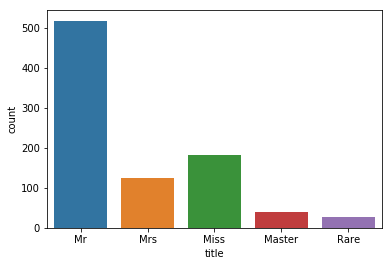

In [39]:
g = sns.countplot(train_df["title"])
# g.set_xticklabels(["Mr", "Miss", "Mrs", "Master", "Rare"])

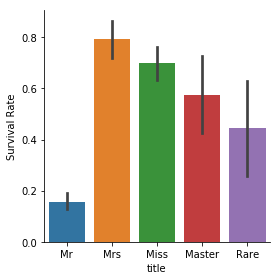

In [40]:
g = sns.factorplot(x = "title", y = "Survived", data = train_df, kind = "bar")
# g.set_xticklabels(["Mr", "Miss", "Mrs", "Master", "Rare"])
g.set_ylabels("Survival Rate")

Women has the highest survival rate

In [41]:
# create a new variable Name_length
train_df['Name_length'] = train_df['Name'].apply(len)

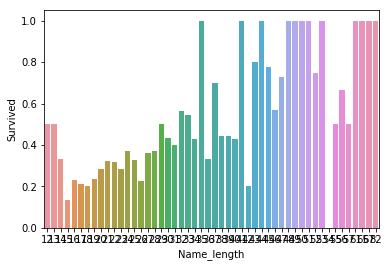

In [42]:
sns.barplot(x='Name_length', y='Survived', data=train_df, ci=None)

#### Ticket

In [43]:
train_df["Ticket"].values[:30]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '349909', '347077', '2631', '19950', '330959', '349216'],
      dtype=object)

In [44]:
train_df['Ticket_length'] = train_df['Ticket'].apply(len)

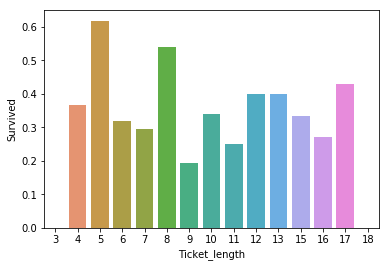

In [45]:
sns.barplot(x='Ticket_length', y='Survived', data=train_df, ci=None)

#### Fare

In [46]:
# reduce skewness
train_df['Fare'] = train_df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

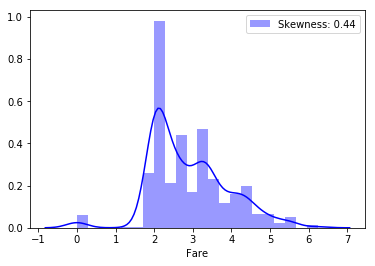

In [47]:
g = sns.distplot(train_df['Fare'], color = 'b', label = 'Skewness: %.2f' 
                 %(train_df['Fare'].skew()))
g.legend(loc='best')

## Function for Feature Engineering

In [48]:
# re-load in train set and test set
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

id_train = train_df['PassengerId']
train_df.drop(labels=['PassengerId'], axis=1, inplace=True)

id_test = test_df['PassengerId']
test_df.drop(labels=['PassengerId'], axis=1, inplace=True)

In [49]:
# age imputation
def age_impute(train_df, test_df):
    age_med = train_df['Age'].median()
    for df in [train_df, test_df]:
        index_NaN = list(df['Age'][df['Age'].isnull()].index)
        for i in index_NaN:
            age_pred = train_df["Age"][((train_df["Pclass"] == train_df.iloc[i]["Pclass"]) &
                                        (train_df["Parch"] == train_df.iloc[i]["Parch"]) &
                                        (train_df["SibSp"] == train_df.iloc[i]["SibSp"]))].median()
            if np.isnan(age_pred):
                df['Age'].iloc[i] = age_med
            else:
                df['Age'].iloc[i] = age_pred
                
    return train_df, test_df

In [50]:
# cabin imputation
def cabin_impute(train_df, test_df):
    cabin_letter = {'A': 1, 'B': 2, 'C': 3, 'D':4, 'E': 5, 'F': 6, 'G': 7, 
                    'T': 8, 'missing': 9}
    for df in [train_df, test_df]:
        df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if x is np.nan else 1)
        df['Cabin_letter'] = df['Cabin'].apply(lambda x: 'missing' if x is np.nan 
                                                   else str(x)[0])
        df['Cabin_letter'] = df['Cabin_letter'].map(cabin_letter)
        # convert cabin letter other than the dict into 0
        df['Cabin_letter'] = df['Cabin_letter'].fillna(0)
        df['Cabin_letter'] = df['Cabin_letter'].astype(int)
        
        del df['Cabin']
    
    return train_df, test_df

In [51]:
# family size
def family_size(train_df, test_df):
    for df in [train_df, test_df]:
        df['Family_size'] = df['Parch'] + df['SibSp'] + 1

    return train_df, test_df

In [52]:
# name
def passenger_name(train_df, test_df):
    title_dict = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3}
    for df in [train_df, test_df]:
        # name length
        df['Name_length'] = df['Name'].apply(len)
        # title
        df_title = df['Name'].str.split(', ', expand=True)[1]
        df_title = df_title.str.split('. ', expand=True)[0]
        df['Title'] = df_title
        df['Title'] = df['Title'].map(title_dict)
        # convert other title into 4
        df['Title'] = df['Title'].fillna(4)
        df['Title'] = df['Title'].astype(int)
        
        del df['Name']
        
    return train_df, test_df

In [53]:
# ticket
def ticket_length(train_df, test_df):
    for df in [train_df, test_df]:
        df['Ticket_length'] = df['Ticket'].apply(len)
        
        del df['Ticket']
    
    return train_df, test_df

In [54]:
# embarked
def embark_impute(train_df, test_df):
    embark_median = train_df['Embarked'].mode()[0]
    for df in [train_df, test_df]:
        df['Embarked'] = df['Embarked'].fillna(embark_median)
        
    return train_df, test_df

In [55]:
# fare
def fare_impute(train_df, test_df):
    fare_median = train_df['Fare'].median()
    for df in [train_df, test_df]:
        df['Fare'] = df['Fare'].fillna(fare_median)
        # reduce skewness
        df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x>0 else 0)
    
    return train_df, test_df

In [56]:
# get dummy variables
def dummies(train_df, test_df, columns):
    for col in columns:
        train_df[col] = train_df[col].apply(lambda x: str(x))
        test_df[col] = test_df[col].apply(lambda x: str(x))
        good_cols = [col+'_'+i for i in train_df[col].unique() if i in test_df[col].unique()]
        train_df = pd.concat((train_df, pd.get_dummies(train_df[col], prefix = col)[good_cols]), axis = 1)
        test_df = pd.concat((test_df, pd.get_dummies(test_df[col], prefix = col)[good_cols]), axis = 1)
        del train_df[col]
        del test_df[col]
        
    return train_df, test_df

In [57]:
train_df, test_df = age_impute(train_df, test_df)
train_df, test_df = cabin_impute(train_df, test_df)
train_df, test_df = family_size(train_df, test_df)
train_df, test_df = passenger_name(train_df, test_df)
train_df, test_df = ticket_length(train_df, test_df)
train_df, test_df = embark_impute(train_df, test_df)
train_df, test_df = fare_impute(train_df, test_df)
dummies_list = ['Pclass', 'Sex', 'Embarked', 'Title']
train_df, test_df = dummies(train_df, test_df, dummies_list)

#### Correlation

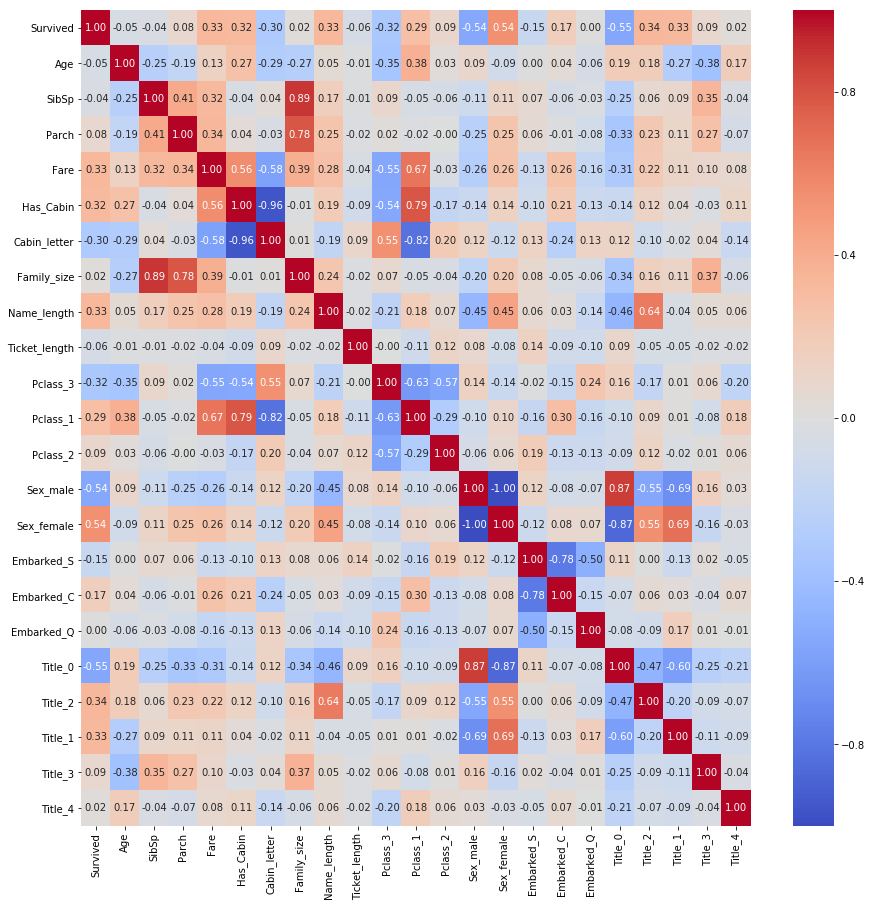

In [58]:
plt.figure(figsize=(15, 15))
sns.heatmap(train_df.astype(float).corr(), annot = True, fmt = ".2f", 
            cmap = "coolwarm")

## 4. Modelling

In [59]:
y_train = train_df['Survived']
X_train = train_df.drop(labels=['Survived'], axis=1)

In [60]:
kfold = StratifiedKFold(n_splits = 10)

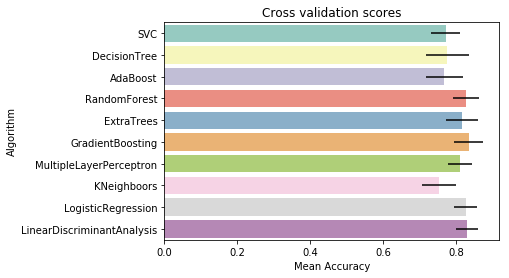

In [61]:
# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(), learning_rate=0.1))
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(MLPClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring = "accuracy", cv=kfold))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means,"CrossValerrors": cv_std,
                       "Algorithm": ["SVC","DecisionTree","AdaBoost",
                       "RandomForest", "ExtraTrees", "GradientBoosting",
                       "MultipleLayerPerceptron", "KNeighboors",
                       "LogisticRegression", "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3",
                orient="h", **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [62]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.771094,0.040640,SVC
1,0.775562,0.059085,DecisionTree
2,0.767646,0.050845,AdaBoost
3,0.827187,0.035692,RandomForest
4,0.817087,0.043687,ExtraTrees
5,0.833941,0.040496,GradientBoosting
6,0.810408,0.034130,MultipleLayerPerceptron
7,0.752056,0.046235,KNeighboors
8,0.826039,0.030661,LogisticRegression
9,0.829422,0.030381,LinearDiscriminantAnalysis


Gradient Boosting has the highest accuracy

choose GradientBoosting, LogisticRegression, RandomForest for the ensemble modeling

#### Hyperparameter tunning

#### Gradient Boosting

In [63]:
# gradient boosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100, 200, 300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100, 150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.1min finished


0.8372615039281706

#### Linear Discrimination Analysis

In [64]:
# Linear Discrimination Analysis
LDAC = LinearDiscriminantAnalysis()
lda_param_grid = {"solver": ["lsqr", "eigen"],
                  "shrinkage": ["auto"],
                  }

gsLDAC = GridSearchCV(LDAC, param_grid = lda_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsLDAC.fit(X_train, y_train)

LDAC_best = gsLDAC.best_estimator_

gsLDAC.best_score_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


0.8305274971941639

#### Logistic Regression

In [65]:
# logistic regression
LRC = LogisticRegression()
lr_param_grid = {"penalty": ["l1", "l2"],
                 "C": [1, 0.5, 0.1, 0.05, 0.01]}

gsLRC = GridSearchCV(LRC, param_grid = lr_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsLRC.fit(X_train, y_train)

LRC_best = gsLRC.best_estimator_

gsLRC.best_score_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


0.8294051627384961

#### RandomForest

In [66]:
# random forest
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 7],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, 
                     scoring = "accuracy", verbose = 1)

gsRFC.fit(X_train, y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  2.3min finished


0.8327721661054994

### 5.3 Learning Curve

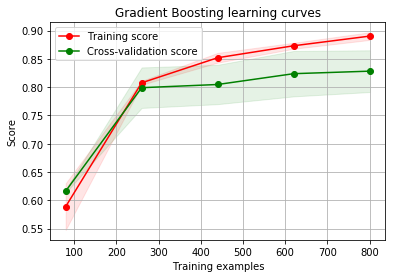

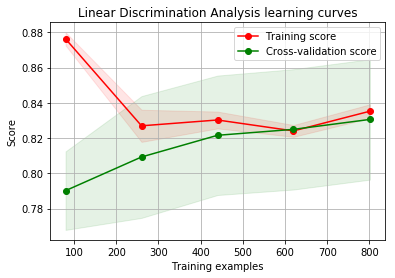

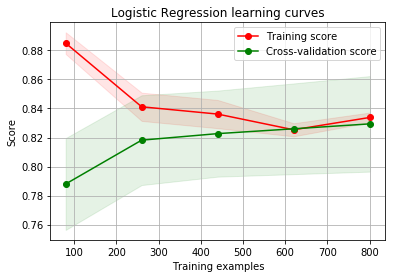

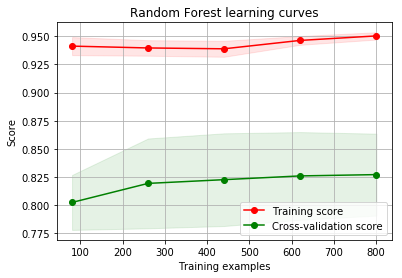

In [67]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, 
                        train_sizes = np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")

    plt.legend(loc = "best")
    return plt

g = plot_learning_curve(gsGBC.best_estimator_,"Gradient Boosting learning curves",
                        X_train, y_train, cv = kfold)
g = plot_learning_curve(gsLDAC.best_estimator_,"Linear Discrimination Analysis learning curves",
                        X_train, y_train, cv = kfold)
g = plot_learning_curve(gsLRC.best_estimator_,"Logistic Regression learning curves",
                        X_train, y_train, cv = kfold)
g = plot_learning_curve(gsRFC.best_estimator_,"Random Forest learning curves",
                        X_train, y_train, cv = kfold)

Random Forest is overfitting, should perform better if more training examples

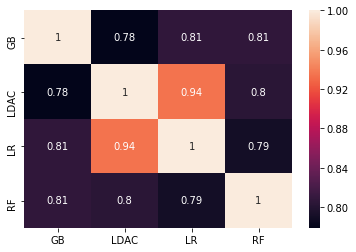

In [68]:
test_Survived_GBC = pd.Series(GBC_best.predict(test_df), name="GB")
test_Survived_LDAC = pd.Series(LDAC_best.predict(test_df), name="LDAC")
test_Survived_LRC = pd.Series(LRC_best.predict(test_df), name="LR")
test_Survived_RFC = pd.Series(RFC_best.predict(test_df), name="RF")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_GBC, test_Survived_LDAC,
                              test_Survived_LRC, test_Survived_RFC 
                              ],
                              axis = 1)


g = sns.heatmap(ensemble_results.corr(), annot=True)

prediction is quite similar => should not be used to ensemble model

#### Ensemble modeling

In [69]:
votingC = VotingClassifier(estimators = [('RF', RFC_best),
                                         ('GB', GBC_best), 
                                         ('LR', LRC_best),
                                         ('LD', LDAC_best)], 
                           voting = 'soft')

votingC = votingC.fit(X_train, y_train)

### 5. Prediction

#### Prediction by Ensemble Model

In [70]:
test_Survived = pd.Series(votingC.predict(test_df), name = "Survived")

results = pd.concat([id_test.reset_index(drop = True),
                     test_Survived], axis = 1)

results.to_csv("ensemble_python_voting.csv", index = False)

#### Prediction by GradientBoosting (Model with highest Accuracy)

In [71]:
GB_result = pd.Series(GBC_best.predict(test_df), name = "Survived")

GB_result = pd.concat([id_test.reset_index(drop = True),
                     GB_result], axis = 1)

GB_result.to_csv("GB_result.csv", index = False)